# Clustering for dataset exploration

In this notebook we will discover the underlying groups (or "clusters") in a dataset. We will be clustering companies using their stock market prices, and distinguishing different species by clustering their measurements.

Overview:
1. [K-means clustering](#Section-1.-K-means-clustering)
    1. [The iris dataset](#Subsection-1.1:-The-iris-dataset)
    1. [Points](#Subsection-1.2-Points)
1. [Evaluating a clustering](#Section-2.-Evaluating-a-clustering)
    1. [Approach 1](#Subsection-2.1:-Approach-1)
    1. [Approach 2: Inertia](#Subsection-2.2:-Approach-2:-Inertia)
1. [Transforming features for better clustering](#Section-3.-Transforming-features-for-better-clustering)
    1. [Scaling wine data for clustering](#Subsection-3.1-Scaling-wine-data-for-clustering)
    1. [Scaling fish data for clustering](#Subsection-3.2-Scaling-fish-data-for-clustering)
    1. [Normalizing stock movements for clustering](#Subsection-3.3-Normalizing-stock-movements-for-clustering)
1. [t-SNE for 2-dimensional maps](#Section-4.-t-SNE-for-2-dimensional-maps)
    1. [The iris dataset](#Subsection-4.1-The-iris-dataset)
    1. [A t-SNE map of the stock market](#Subsection-4.2-A-t-SNE-map-of-the-stock-market)

In [1]:
from sklearn.cluster import KMeans
from sklearn import datasets
from sklearn.utils import Bunch
from sklearn.preprocessing import StandardScaler, Normalizer, normalize
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

import matplotlib.pyplot as plt
from typing import Dict, List, Tuple, Union
import pandas as pd
import numpy as np
import seaborn as sns
import os

from pandas.core.frame import DataFrame, Series
from numpy.core import ndarray, int32, float64

%matplotlib inline

In [2]:
basedir: str = os.getcwd()

In [3]:
def normabspath(basedir: str, filename: str):
    return os.path.normpath(os.path.join(basedir, filename))

In [4]:
datafiles: Dict[str, str] = dict(seeds='data/grains/seeds.csv',
                                 seeds_width_vs_length='data/grains/seeds-width-vs-length.csv',
                                 stocks='data/company-stock-movements-2010-2015-incl.csv',
                                 wine='data/wine.csv',
                                 eurovision='data/eurovision-2016.csv')

datapaths: Dict[str, str] = {k: normabspath(basedir, v) for k, v in datafiles.items()}

## Section 1. K-means clustering

In this section, we will cluster our samples using k-means clustering. This model finds a specified number of clusters in the samples.

### Subsection 1.1: The iris dataset

First, we load the Iris dataset:

In [5]:
iris: Bunch = datasets.load_iris()
iris_features: DataFrame = pd.DataFrame(data=iris['data'], columns=iris.feature_names)
iris_features.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2


#### Explanatory Data Analysis (EDA)

Above, we can observe that the features of the iris dataset consists of 4 measurements, and therefore this dataset has 4 dimensions:
* Sepal length
* Sepal width
* Petal length
* Petal width

The target variable encodes the species of flower, and there are 3 possibilities as shown below:
* Setosa
* Versicolor
* Virginica

In [6]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

We know from the target names array shown above that
* Setosa corresponds to index `0`
* Versicolor corresponds to index `1`
* Virginica corresponds to index `2`

Thus, we can build this dictionary:

In [7]:
labels_species: Dict[int, str] = dict(zip(range(3), iris.target_names))
labels_species

{0: 'setosa', 1: 'versicolor', 2: 'virginica'}

In [8]:
iris.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [9]:
print(iris.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [10]:
X: ndarray = iris.data
y: ndarray = iris.target

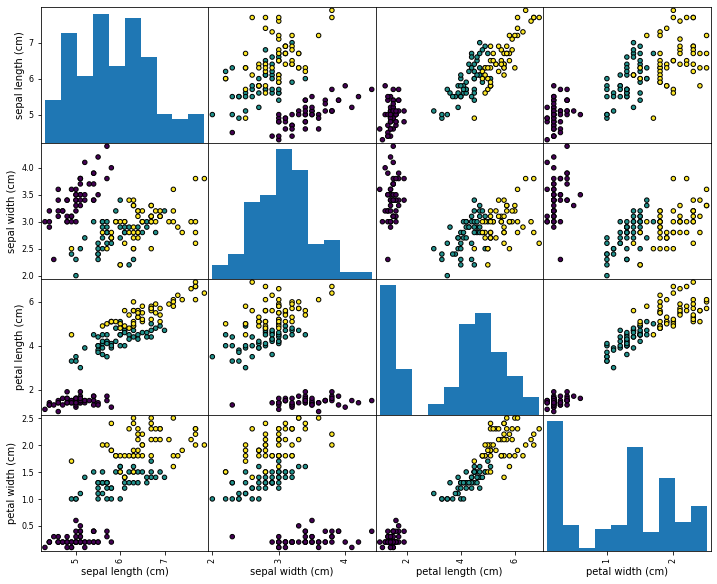

In [11]:
pd.plotting.scatter_matrix(iris_features, figsize=(12, 10), c=(y - 1), alpha=1, edgecolors='k', s=80)
plt.show()

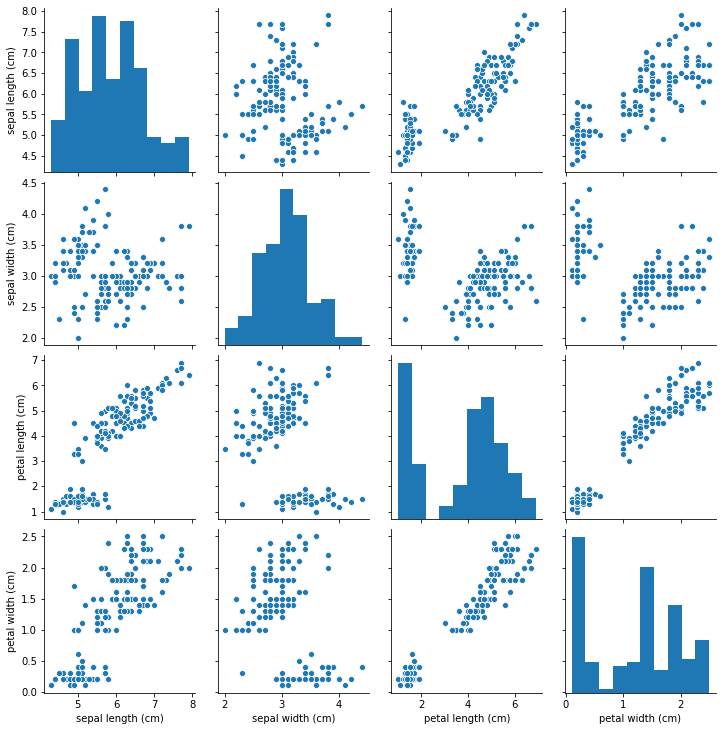

In [12]:
sns.pairplot(iris_features)
plt.show()

Let's specify 3 clusters as there are 3 species of iris. Let's fit the model to the data.

In [13]:
samples: ndarray = iris.data[:-10]
kmeans_model = KMeans(n_clusters=3)
kmeans_model.fit(samples)

KMeans(n_clusters=3)

The fitting is done by locating and memorizing the regions where the different clusters are located.

We can now use the `.predict()` method. This returns a cluster label for each sample, indicating to which cluster a sample belongs.

In [14]:
labels: ndarray = kmeans_model.predict(samples)
labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 2, 2, 2, 1, 2, 2, 2,
       2, 2, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 2, 1, 2, 2, 1, 1, 2, 2, 2, 2,
       2, 1, 2, 2, 2, 2, 1, 2])

k-means remembers the mean of each cluster. These are called the "_centroids_". Therefore, new samples are assigned to the cluster whose centroid is the closest.

In [15]:
new_samples: ndarray = iris.data[-10:]
new_labels = kmeans_model.predict(new_samples)
new_labels

array([2, 2, 1, 2, 2, 2, 1, 2, 2, 1])

In [16]:
sepal_petal_len: DataFrame = iris_features.iloc[:-10, :].filter(regex='length', axis=1)
sepal_petal_len.head(3)

,sepal length (cm),petal length (cm)
0,5.1,1.4
1,4.9,1.4
2,4.7,1.3


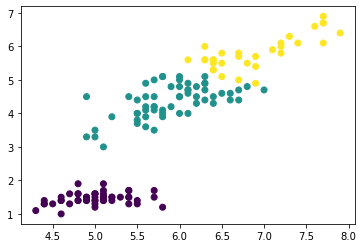

In [17]:
sepal_len: Series = sepal_petal_len.filter(regex='sepal', axis=1)
petal_len: Series = sepal_petal_len.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels)
plt.show()

In [18]:
centroids_iris: DataFrame = pd.DataFrame(data=kmeans_model.cluster_centers_, columns=iris.feature_names)
centroids_iris.head(3)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
0,5.006000,3.428000,1.462000,0.246000
1,5.896610,2.749153,4.359322,1.411864
2,6.896774,3.054839,5.809677,2.019355


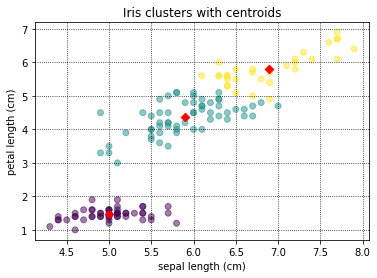

In [19]:
sepal_petal_len_centroids: DataFrame = centroids_iris.filter(regex='length', axis=1)
sepal_len_centroids = sepal_petal_len_centroids.filter(regex='sepal', axis=1)
petal_len_centroids = sepal_petal_len_centroids.filter(regex='petal', axis=1)

plt.scatter(sepal_len, petal_len, c=labels, alpha=0.5)
plt.scatter(sepal_len_centroids, petal_len_centroids, c='r', marker='D')
plt.title('Iris clusters with centroids')
plt.xlabel(sepal_len.columns[0])
plt.ylabel(petal_len.columns[0])
plt.grid(True, c='k', ls=':')
plt.show()

### Subsection 1.2 Points

In [20]:
class Load_txt:
    '''
    Load data from a text file. Has extra parameter `nan_values` that np.loadtxt has not.
    '''
    def __init__(self, filename: str, basedir: str = None, nan_value: str = 'NA', delimiter: Union[str, None] = None):
        self.filename: str = str(filename)
        self.basedir: str = str(basedir) if not None else None
        self.path: str = os.path.normpath(os.path.join(self.basedir, self.filename)) if self.basedir is not None else os.path.normpath(self.filename)
        self.nan_value: Union[str, float] = nan_value
        self.delimiter: Union[str, None] = delimiter if isinstance(delimiter, str) else None
    
    def to_numpy(self) -> ndarray:
        with open(self.path, mode='r') as f:            
            for i, line in enumerate(f.readlines()):
                
                splitted_line: List[str] = line.strip('\n').split(self.delimiter) if isinstance(self.delimiter, str) else line.strip('\n').split()
                
                if i == 0:
                    data: ndarray = np.array(list(map(self.__convert_data, splitted_line)))
                else:
                    row: ndarray = np.array(list(map(self.__convert_data, splitted_line)))
                    data: ndarray = np.vstack((data, row))
        return data
    
    def __convert_data(self, data_observation: str) -> Union[float, None]:
        return float(data_observation) if data_observation != self.nan_value else np.nan
        


def load_txt(filename: str, basedir: str, nan_value: str = 'NA'):
    path: str = os.path.normpath(os.path.join(basedir, filename))
    with open(filename, mode='r') as f:
        for i, line in enumerate(f.readlines()):
            if i == 0:              
                data: ndarray = np.array(list(map(float, line.strip('\n').split(', '))))
            else:
                row = np.array(list(map(float, line.strip('\n').split(', '))))
                data = np.vstack((data, row))
    return data

In [21]:
points: ndarray = Load_txt('data/points.txt', basedir, delimiter=', ').to_numpy()
new_points: ndarray = Load_txt('data/new_points.txt', basedir, delimiter=', ').to_numpy()
print(points.shape)

(300, 2)


We are given an array `points` of size 300x2, where each row gives the (x, y) coordinates of a point on a map. We will first make a scatter plot of these points, and use the scatter plot to guess how many clusters there are.

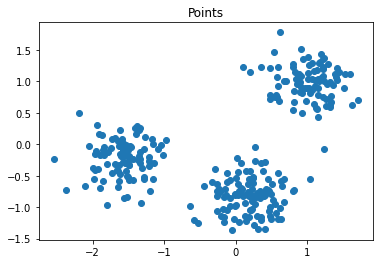

In [22]:
xs: ndarray = points[:, 0]
ys: ndarray = points[:, 1]
plt.scatter(xs, ys)
plt.title('Points')
plt.show()

The scatter plot suggests that there are 3 distinct clusters. We will now create a KMeans model to find 3 clusters, and fit it to the data points. After the model has been fit, we will obtain the cluster labels for some *new points* using the `.predict()` method.

In [23]:
model = KMeans(n_clusters=3)
model.fit(points)
labels = model.predict(new_points)
labels

array([0, 1, 2, 0, 1, 0, 1, 1, 1, 2, 0, 1, 1, 2, 2, 1, 2, 2, 1, 1, 2, 1,
       0, 1, 0, 2, 1, 2, 2, 0, 0, 1, 1, 1, 2, 0, 1, 1, 0, 1, 2, 0, 0, 2,
       0, 1, 2, 2, 1, 1, 1, 1, 2, 2, 0, 0, 2, 2, 2, 0, 0, 1, 1, 1, 0, 1,
       2, 1, 0, 2, 0, 0, 0, 1, 0, 2, 2, 0, 1, 2, 0, 2, 0, 1, 2, 1, 2, 0,
       1, 1, 1, 0, 1, 1, 0, 2, 2, 2, 2, 0, 1, 0, 2, 2, 0, 0, 1, 0, 2, 2,
       0, 2, 2, 2, 1, 1, 1, 1, 2, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 2, 1, 2,
       1, 2, 0, 1, 0, 0, 1, 2, 0, 1, 0, 0, 2, 1, 1, 0, 2, 0, 2, 1, 0, 2,
       2, 0, 2, 1, 1, 2, 1, 2, 2, 1, 1, 0, 1, 1, 2, 0, 2, 0, 0, 1, 0, 1,
       1, 0, 0, 2, 0, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 1, 1, 1, 0, 1, 1, 1,
       2, 2, 0, 1, 0, 0, 0, 2, 1, 1, 1, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 1,
       2, 2, 1, 1, 0, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 1, 1, 1, 2, 0, 0,
       2, 1, 1, 2, 1, 2, 2, 1, 2, 2, 0, 2, 0, 0, 0, 1, 2, 2, 2, 0, 1, 0,
       2, 0, 2, 2, 1, 0, 0, 0, 2, 1, 1, 1, 0, 1, 2, 2, 1, 0, 0, 2, 0, 0,
       2, 0, 1, 0, 2, 2, 2, 2, 1, 2, 2, 1, 1, 0])

We have successfully performed k-Means clustering and predicted the labels of new points. But it is not easy to inspect the clustering by just looking at the printed labels. A visualization would be far more useful.  Below, we will inspect our clustering with a scatter plot!

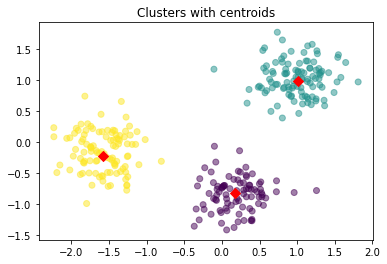

In [24]:
xs: ndarray = new_points[:, 0]
ys: ndarray = new_points[:, 1]

plt.scatter(xs, ys, c=labels, alpha=0.5)

centroids = model.cluster_centers_

centroids_x = centroids[:, 0]
centroids_y = centroids[:, 1]

plt.scatter(centroids_x, centroids_y, marker='D', s=50, c='r')
plt.title('Clusters with centroids')
plt.show()

## Section 2. Evaluating a clustering

We have seen how to use k-means to cluster the iris samples into three clusters. But how can we evaluate the quality of this clustering?

There are 2 approaches.

1. The direct approach is to **compare the clusters with the iris species**. A **drawback** of this approach is that it requires our samples to come pre-grouped into species.
1. **Inertia**: Measure the quality of a clustering that does **not** require our samples to come pre-grouped into species. This method of quality can then be used to make an informed choice about the number of clusters to look for.

### Subsection 2.1: Approach 1

Let's check whether the 3 clusters of iris samples have any correspondence to the iris species. The correspondence can be described by tables usually called *cross-tabulations*.

First, we create this 2-column DataFrame so that each row gives the cluster label and the species of a single sample.

In [25]:
df = pd.DataFrame(data=iris.target, columns=['labels'])
df['species'] = df.labels.apply(lambda x: labels_species[x])
df

,labels,species
0,0,setosa
1,0,setosa
2,0,setosa
3,0,setosa
4,0,setosa
...,...,...
145,2,virginica
146,2,virginica
147,2,virginica
148,2,virginica


The first column contains the cluster labels, and the second column is the iris species.

Next, we can use the `pandas.crosstab` method to build the cross-tabulation:

In [26]:
ct_iris: DataFrame = pd.crosstab(df.labels, df.species)
ct_iris

species,setosa,versicolor,virginica
labels,,,
0,50,0,0
1,0,50,0
2,0,0,50


Cross-tabulations like this provide great insights into which sort of samples are in which cluster.

In [27]:
# df = pd.get_dummies(datasets.load_iris(as_frame=True).target)
# df.columns = iris.target_names
# df.mul(iris.target_names)

### Subsection 2.2: Approach 2: Inertia
In most datasets samples are not labelled by species. So, how can the quality of a clustering be evaluated in these cases?

We need a way to measure the quality of clustering that uses only the clusters and the samples themselves.

A **good clustering** has tight clusters. Therefore, the idea for measuring the quality of clustering can be defined as follows:
* How spread out the samples whithin each cluster can be measured by the **inertia**
* Lower values for this metric is better

Intuitively, **intertia** measures **how far samples are from their centroids**.

The **inertia** of a k-means model is measured automatically when any of the `.fit()` method is called, and is available afterwards as the `.inertia_` attribute.

Here is a plot of the inertia values of clusterings of the iris dataset with different numbers of clusters:

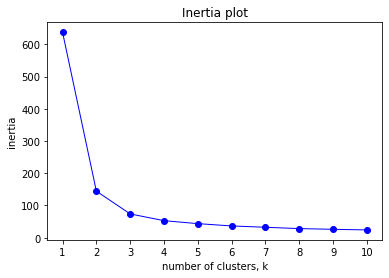

In [28]:
ks = range(1, 11)
inertias: List[float] = []

for k in ks:
    model = KMeans(n_clusters=k)
    
    model.fit(samples)
    
    inertias.append(model.inertia_)
    
plt.plot(ks, inertias, '-o', c='b', lw=1)
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.title('Inertia plot')
plt.show()

We also notice that inertia decreases slowly as the numbers of clusters increases. The subsequent question that raises is: **What is the best number of clusters?**

This is a trade-off. A good clustering has tight clusters. That is, low inertia. But, a good clustering should also not have too many clusters.

Therefore, a good **rule of thumb** is to choose an **elbow** in the intertia plot.

Hence, conclude from the inertia plot that 3 is a good number of clusters for the iris dataset. 

## Section 3. Transforming features for better clustering

### Subsection 3.1 Scaling wine data for clustering

We will now turn on another dataset: the Piedmont wines dataset. Source: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Wine).

We have a 178 samples of red wine from the Piedmont region of Italy. There are 3 distinct varieties:
* Barolo
* Grignolino
* Barbera

The **features** measure chemical composition (like alcohol content), and visual properties like color intensity.

In [29]:
wine = pd.read_csv(os.path.normpath(os.path.join(basedir, 'data/wine.csv')))
wine

,class_label,class_name,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280,proline
0,1,Barolo,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,Barolo,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,Barolo,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,Barolo,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,Barolo,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,3,Barbera,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740
174,3,Barbera,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750
175,3,Barbera,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835
176,3,Barbera,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840


#### A. Without feature standardization

Let's take the array of samples and use k-means to find 3 clusters.

In [30]:
samples: DataFrame = wine.iloc[:, 2:]
model = KMeans(n_clusters=3, random_state=4)
labels: ndarray = model.fit_predict(samples)
labels

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 0, 2, 0, 2, 2, 0,
       2, 2, 0, 0, 0, 2, 2, 1, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 0, 2, 2, 2, 2, 2, 0, 0, 2, 0, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 0,
       2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2,
       2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 0,
       0, 0, 2, 0, 0, 0, 2, 0, 2, 0, 0, 2, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0,
       0, 2])

In [31]:
df: DataFrame = pd.DataFrame(data=dict(labels=labels, varieties=wine['class_name']))
ct: DataFrame = pd.crosstab(df['labels'], df['varieties'])
ct

varieties,Barbera,Barolo,Grignolino
labels,,,
0,29,13,20
1,0,46,1
2,19,0,50


This time, the k-means clusters didn't correspond well with the wine varieties.

The problem is that **the features of the wine dataset have very different variances**. As a recall, the variance of a feature measures the spread of its values.

For example, the malic acid feature has a higher variance than the od280 feature. This can be seen from the scatter plot below.

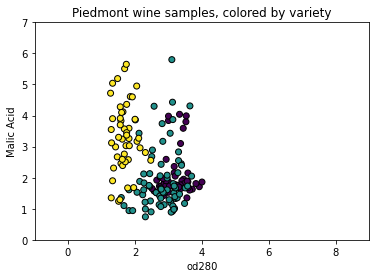

In [32]:
plt.scatter(wine.od280, wine.malic_acid, c=wine['class_label'], edgecolors='k')
plt.ylabel('Malic Acid')
plt.xlabel('od280')
plt.ylim([0, 7])
plt.xlim([-1, 9])
plt.title('Piedmont wine samples, colored by variety')
plt.show()

In [33]:
wine.var()

class_label                 0.600679
alcohol                     0.659062
malic_acid                  1.248015
ash                         0.075265
alcalinity_of_ash          11.152686
magnesium                 203.989335
total_phenols               0.391690
flavanoids                  0.997719
nonflavanoid_phenols        0.015489
proanthocyanins             0.327595
color_intensity             5.374449
hue                         0.052245
od280                       0.504086
proline                 99166.717355
dtype: float64

The differences in some of the feature variances is enormous as seen here, for example, in the scatter plot of the od280 versus proline features!

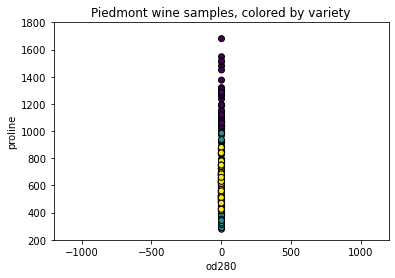

In [34]:
plt.scatter(wine.od280, wine.proline, c=wine.class_label, edgecolors='k')
plt.ylabel('proline')
plt.ylim([200, 1800])
plt.xlabel('od280')
plt.xlim([-1200, 1200])
plt.title('Piedmont wine samples, colored by variety')
plt.show()

In k-means clustering, **the variance of a feature corresponds to its influence on the clustering algorithm**. In short: $\text{feature variance} = \text{feature influence}$.

#### B. With feature standardization

To give every feature a chance, the data needs to be transformed so that features have **equal variance**. This can be achieved with the `StandardScaler` from scikit-learn which transforms each feature to have mean 0 and variance 1.

Eventually, the resulting "standardized" features can be very informative.

Using standardized od280 and proline, for instance, the 3 wine varieties are much more distinct.

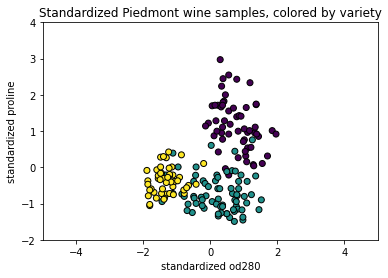

In [35]:
scaler = StandardScaler()
scaler.fit(samples)
standardized_wine = pd.DataFrame(data=scaler.transform(samples), columns=samples.columns)

plt.scatter(standardized_wine.od280, standardized_wine.proline, c=wine['class_label'], edgecolors='k')
plt.ylabel('standardized proline')
plt.ylim([-2, 4])
plt.xlabel('standardized od280')
plt.xlim([-5, 5])
plt.title('Standardized Piedmont wine samples, colored by variety')
plt.show()

In [36]:
# Standardize features with a pipeline
scaler = StandardScaler()
kmeans = KMeans(n_clusters=3, random_state=21)
pipeline = make_pipeline(scaler, kmeans)
labels: ndarray = pipeline.fit_predict(samples)
    
# Cross-tabulation
df: DataFrame = pd.DataFrame(data=dict(labels=labels, varieties=wine['class_name']))
ct: DataFrame = pd.crosstab(df['labels'], df['varieties'])
ct

varieties,Barbera,Barolo,Grignolino
labels,,,
0,0,59,3
1,48,0,3
2,0,0,65


Checking the correspondence between the cluster labels and the wine varieties reveals that this new clustering, incorporating standardization, is fantastic! Its 3 clusters correspond almost exactly to the 3 wine varieties. This is a huge improvement on the clustering without standardization.

### Subsection 3.2 Scaling fish data for clustering

These fish measurement data were sourced from the [Journal of Statistics Education](http://jse.amstat.org/jse_data_archive.htm).

We are given dataset giving measurements of fish. Each row represents an individual fish. The measurements, such as weight in grams, length in centimeters, and the percentage ratio of height to length, have very different scales. In order to cluster this data effectively, we'll need to standardize these features first. We won't focus on categorical data. Therefore, we'll drop the 'Sex' column, later.

The description of the dataset is provided in this [file](http://jse.amstat.org/datasets/fishcatch.txt).

In [37]:
fish: ndarray = Load_txt('data/fishcatch.dat.txt', basedir, nan_value='NA').to_numpy()
cols: List[str] = ['Labels', 'Weight', 'Length1', 'Length2', 'Length3', 'Height%', 'Width%', 'Sex']   
fish_data: DataFrame = pd.DataFrame(data=fish[:, 1:], index=map(int, fish[:, 0]), columns=cols)
fish_data.Labels = fish_data.Labels.astype(int)
fish_data[['Labels', 'Sex']] = fish_data[['Labels', 'Sex']].astype('category')
fish_data

,Labels,Weight,Length1,Length2,Length3,Height%,Width%,Sex
1,1,242.0,23.2,25.4,30.0,38.4,13.4,NaN
2,1,290.0,24.0,26.3,31.2,40.0,13.8,NaN
3,1,340.0,23.9,26.5,31.1,39.8,15.1,NaN
4,1,363.0,26.3,29.0,33.5,38.0,13.3,NaN
5,1,430.0,26.5,29.0,34.0,36.6,15.1,NaN
...,...,...,...,...,...,...,...,...
155,7,1100.0,39.0,42.0,44.6,28.7,15.4,0.0
156,7,1000.0,39.8,43.0,45.2,26.4,16.1,0.0
157,7,1100.0,40.1,43.0,45.5,27.5,16.3,0.0
158,7,1000.0,40.2,43.5,46.0,27.4,17.7,1.0


In [38]:
species: Tuple[str] = ('Bream', 'Whitewish', 'Roach', '?', 'Smelt', 'Pike', 'Perch')
species_dict: Dict[int, str] = {i+1: fish for i, fish in enumerate(species)}
fish_data['Species'] = fish_data.Labels.apply(lambda x: species_dict[x])
fish_data

,Labels,Weight,Length1,Length2,Length3,Height%,Width%,Sex,Species
1,1,242.0,23.2,25.4,30.0,38.4,13.4,NaN,Bream
2,1,290.0,24.0,26.3,31.2,40.0,13.8,NaN,Bream
3,1,340.0,23.9,26.5,31.1,39.8,15.1,NaN,Bream
4,1,363.0,26.3,29.0,33.5,38.0,13.3,NaN,Bream
5,1,430.0,26.5,29.0,34.0,36.6,15.1,NaN,Bream
...,...,...,...,...,...,...,...,...,...
155,7,1100.0,39.0,42.0,44.6,28.7,15.4,0.0,Perch
156,7,1000.0,39.8,43.0,45.2,26.4,16.1,0.0,Perch
157,7,1100.0,40.1,43.0,45.5,27.5,16.3,0.0,Perch
158,7,1000.0,40.2,43.5,46.0,27.4,17.7,1.0,Perch


In [39]:
fishes = ('Bream', 'Roach', 'Smelt', 'Pike')
fish_samples = fish_data[fish_data.Species.isin(fishes)]
fish_samples.reset_index(inplace=True, drop=True)
fish_samples

,Labels,Weight,Length1,Length2,Length3,Height%,Width%,Sex,Species
0,1,242.0,23.2,25.4,30.0,38.4,13.4,NaN,Bream
1,1,290.0,24.0,26.3,31.2,40.0,13.8,NaN,Bream
2,1,340.0,23.9,26.5,31.1,39.8,15.1,NaN,Bream
3,1,363.0,26.3,29.0,33.5,38.0,13.3,NaN,Bream
4,1,430.0,26.5,29.0,34.0,36.6,15.1,NaN,Bream
...,...,...,...,...,...,...,...,...,...
81,6,950.0,48.3,51.7,55.1,16.2,11.2,NaN,Pike
82,6,1250.0,52.0,56.0,59.7,17.9,11.7,NaN,Pike
83,6,1600.0,56.0,60.0,64.0,15.0,9.6,NaN,Pike
84,6,1550.0,56.0,60.0,64.0,15.0,9.6,0.0,Pike


In [40]:
fish_sample_features: DataFrame = fish_samples.drop(['Labels', 'Species', 'Sex'], axis=1)
fish_sample_y: DataFrame = fish_samples[['Labels', 'Species']]
fish_sample_y

,Labels,Species
0,1,Bream
1,1,Bream
2,1,Bream
3,1,Bream
4,1,Bream
...,...,...
81,6,Pike
82,6,Pike
83,6,Pike
84,6,Pike


In [41]:
fish_sample_features.dropna(inplace=True)
fish_sample_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 85 entries, 0 to 85
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Weight   85 non-null     float64
 1   Length1  85 non-null     float64
 2   Length2  85 non-null     float64
 3   Length3  85 non-null     float64
 4   Height%  85 non-null     float64
 5   Width%   85 non-null     float64
dtypes: float64(6)
memory usage: 4.6 KB


We'll now use standardization and clustering pipeline to cluster the fish by their measurements, and then create a cross-tabulation to compare the cluster labels with the fish species.

In [42]:
scaler = StandardScaler()
kmeans = KMeans(n_clusters=4, random_state=12)
pipeline = make_pipeline(scaler, kmeans)
labels = pipeline.fit_predict(fish_sample_features.to_numpy())
ct = pd.crosstab(fish_sample_y.Labels, fish_sample_y.Species)
ct

Species,Bream,Roach,Smelt,Pike
Labels,,,,
1,35,0,0,0
3,0,20,0,0
5,0,0,14,0
6,0,0,0,17


It looks like the fish data separates really well into 4 clusters!

### Subsection 3.3 Normalizing stock movements for clustering

The question we want to answer here is: Which stocks move together?

With the next dataset we will cluster companies using their daily stock price movements (i.e. the dollar difference between the closing and opening prices for each trading day). We are given daily price movements from 2010 to 2015 (obtained from Yahoo! Finance), where each row corresponds to a company, and each column corresponds to a trading day.

To achieve this we'll cluster companies by their daily stock price movements using K-Means. We'll inspect the cluster labels from our clustering to find out which company have stock prices that tend to change in the same way.

Some stocks are more expensive than others. To account for this, include a `Normalizer` at the beginning of our pipeline. The `Normalizer` will separately transform each company's stock price to a relative scale before the clustering begins.

Note that `Normalizer()` is different to `StandardScaler()`, which wou used in the previous study case. While `StandardScaler()` standardizes **features** (such as the features of the fish data from the previous study case) by removing the mean and scaling to unit variance, `Normalizer()` rescales **each sample** &ndash; here, each company's stock price &ndash; independently of the other.

In [43]:
filename: str = normabspath(basedir, 'data/company-stock-movements-2010-2015-incl.csv')

stocks = pd.read_csv(filename).T

# Set the first row as header
companies: Tuple[str] = tuple(stocks.iloc[0, :])
stocks.columns = companies

# Drop first row
stocks.drop(stocks.index[0], inplace=True)

# dtypes of the DataFrame are all 'object' which we convert to 'float'
stocks = stocks.astype(float)

# Convert index dtype from 'object' to 'datetime64[ns]'
stocks.index = pd.to_datetime(stocks.index)
stocks.index = stocks.index.to_period("D")

stocks = stocks.T

stocks.head()

,2010-01-04,2010-01-05,2010-01-06,2010-01-07,2010-01-08,2010-01-11,2010-01-12,2010-01-13,2010-01-14,2010-01-15,...,2013-10-16,2013-10-17,2013-10-18,2013-10-21,2013-10-22,2013-10-23,2013-10-24,2013-10-25,2013-10-28,2013-10-29
Apple,0.580000,-0.220005,-3.409998,-1.170000,1.680011,-2.689994,-1.469994,2.779997,-0.680003,-4.999995,...,0.320008,4.519997,2.899987,9.590019,-6.540016,5.959976,6.910011,-5.359962,0.840019,-19.589981
AIG,-0.640002,-0.650000,-0.210001,-0.420000,0.710001,-0.200001,-1.130001,0.069999,-0.119999,-0.500000,...,0.919998,0.709999,0.119999,-0.480000,0.010002,-0.279998,-0.190003,-0.040001,-0.400002,0.660000
Amazon,-2.350006,1.260009,-2.350006,-2.009995,2.960006,-2.309997,-1.640007,1.209999,-1.790001,-2.039994,...,2.109985,3.699982,9.570008,-3.450013,4.820008,-4.079986,2.579986,4.790009,-1.760009,3.740021
American express,0.109997,0.000000,0.260002,0.720002,0.190003,-0.270001,0.750000,0.300004,0.639999,-0.130001,...,0.680001,2.290001,0.409996,-0.069999,0.100006,0.069999,0.130005,1.849999,0.040001,0.540001
Boeing,0.459999,1.770000,1.549999,2.690003,0.059997,-1.080002,0.360000,0.549999,0.530002,-0.709999,...,1.559997,2.480003,0.019997,-1.220001,0.480003,3.020004,-0.029999,1.940002,1.130005,0.309998


In [44]:
normalizer = Normalizer()
kmeans = KMeans(n_clusters=10)

# Make a pipeline chaining normalizer and kmeans
pipeline = make_pipeline(normalizer, kmeans)

# Fit pipeline to the daily price movements
labels: ndarray = pipeline.fit_predict(stocks)

df = pd.DataFrame({'labels': labels, 'companies': companies})

# Display df sorted by cluster label
df.sort_values('labels')

,labels,companies
27,0,Kimberly-Clark
40,0,Procter Gamble
9,0,Colgate-Palmolive
44,1,Schlumberger
49,1,Total
13,1,DuPont de Nemours
12,1,Chevron
10,1,ConocoPhillips
53,1,Valero Energy
35,1,Navistar


We used k-means clustering to cluster companies according to their stock price movements. Now, we'll perform hierarchical clustering of the companies. 

SciPy hierarchical clustering doesn't fit into a sklearn pipeline, so we'll need to use the `normalize()` function from `sklearn.preprocessing` instead of `Normalizer`.

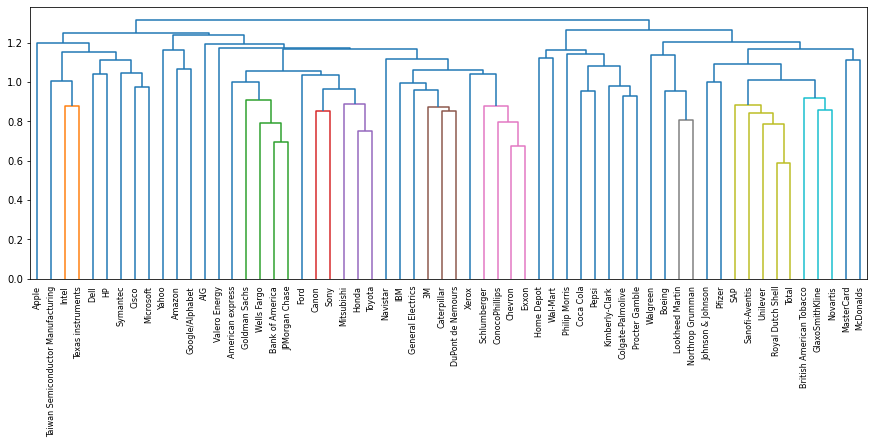

In [45]:
normalized_movements: ndarray = normalize(stocks)

# Calculate the linkage
mergings: ndarray = linkage(normalized_movements, method='complete')

fig = plt.figure(figsize=(15, 5))
dendrogram(mergings, labels=companies, leaf_rotation=90, leaf_font_size=8)
plt.show()

## Section 4. Cluster labels in hierarchical clustering

In [46]:
grains: DataFrame = pd.read_csv(datapaths['seeds'], header=None)
varieties: Dict[int, str] = {1: 'Kama wheat', 2: 'Rosa wheat', 3: 'Canadian wheat'}
grains['varieties'] = grains[7].apply(lambda x: varieties[x])  

X_grains: ndarray = grains.iloc[:, :-2].to_numpy()
y_grains: ndarray = grains.iloc[:, -2:].to_numpy()
grains

,0,1,2,3,4,5,6,7,varieties
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220,1,Kama wheat
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956,1,Kama wheat
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825,1,Kama wheat
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805,1,Kama wheat
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175,1,Kama wheat
...,...,...,...,...,...,...,...,...,...
205,12.19,13.20,0.8783,5.137,2.981,3.631,4.870,3,Canadian wheat
206,11.23,12.88,0.8511,5.140,2.795,4.325,5.003,3,Canadian wheat
207,13.20,13.66,0.8883,5.236,3.232,8.315,5.056,3,Canadian wheat
208,11.84,13.21,0.8521,5.175,2.836,3.598,5.044,3,Canadian wheat


In [47]:
mergings: ndarray = linkage(X_grains, method='complete')
labels: ndarray = fcluster(mergings, t=8, criterion='distance')
df = pd.DataFrame({'labels': labels, 'varieties': grains.varieties.to_numpy()})
ct = pd.crosstab(df.labels, df.varieties)
ct

varieties,Canadian wheat,Kama wheat,Rosa wheat
labels,,,
1,0,0,47
2,0,52,23
3,70,18,0


## Section 4. t-SNE for 2-dimensional maps

In this section, we'll learn about an unsupervised learning method for visualization called "t-SNE". t-SNE stands for *t-distributed stochastic neighbor embedding*. This technique maps samples from their high-dimensional space into a 2- or 3-dimensional space so that they can be visualized.

While some distortion is inevitable, t-SNE does a great job of approximately **representing the distances between the samples**. For this reason, t-SNE is a valuable visual aid for understanding and inspecting a dataset.

### Subsection 4.1 The iris dataset
To see what sorts of insights are possible with t-SNE, let's look at how it performs on the iris dataset.

The iris samples are in a 4-dimensional space, where each dimension corresponds to one of the 4 iris measurements (petal & sepal length and petal & sepal width).

We'll give t-SNE only the measurement of the iris samples. In particular, we won't provide any information about the 3 species of iris. But if we color the species differently on the scatter plot, we see that t-SNE has kept the species separate.

NB: t-SNE does not have separate `.fit()` and `.transform()` methods. Meaning, that we can't extend a t-SNE map to include new samples. Instead, we habe to start over each time.

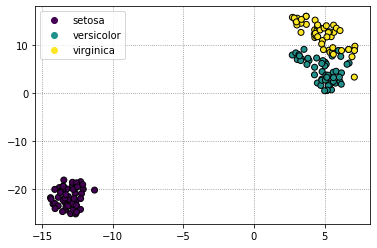

In [48]:
model = TSNE(learning_rate=100)
tsne_features: ndarray = model.fit_transform(iris.data)
xs: ndarray = tsne_features[:, 0]
ys: ndarray = tsne_features[:, 1]
scatter = plt.scatter(xs, ys, c=iris.target, edgecolor='k')
plt.grid(True, c='k', ls=':', alpha=0.5)
plt.legend(*scatter.legend_elements()[:-1], iris.target_names)
plt.show()

This scatter plot gives us a new insight. We learn hat there are two iris species, versicolor and virginica, whose samples are close together in space. So, it could happend that the iris dataset appears to have 2 clusters, instead of 3! This is compatible with our previous examples using k-means in [subsection 2.2](#Subsection-2.2:-Approach-2:-Inertia), where we saw that a clustering with 2 clusters also had relatively low inertia (i.e., tight clusters).

t-SNE **learning rate** makes the use to this unsupervised learning method more complicated than some other techniques. We may need to try different learning rate for different datasets. It is clear, however, when we have made a bad choice. Because all the samples appear bunched together in the scatter plot. Normally, it's enough to try a few values between 50 and 200.

In [49]:
def create_tsne(data: ndarray, lr: int = 100) -> Tuple[TSNE, ndarray]:
    model = TSNE(learning_rate=100)
    tsne_features: ndarray = model.fit_transform(data)
    return model, tsne_features

In [50]:
def tsne_subplots(data: ndarray, learning_rates: tuple = (100, ), color_labels=None, legend_labels=None):
    fig, axs = plt.subplots(3, 1, figsize=(6, 8))
    for i, lr in enumerate(learning_rates):
        _, tsne_features = create_tsne(data, lr)
        xs: ndarray = tsne_features[:, 0]
        ys: ndarray = tsne_features[:, 1]
        scatter = axs[i].scatter(xs, ys, c=color_labels, edgecolors='k')
        axs[i].set_title(f"t-SNE with learning rate = {lr}")
        axs[i].grid(True, ls=':', c='k', alpha=0.5)
        if legend_labels is not None:
            axs[i].legend(*scatter.legend_elements()[:-1], legend_labels)
        else:
            axs[i].legend(*scatter.legend_elements())
    fig.tight_layout()
    plt.show()

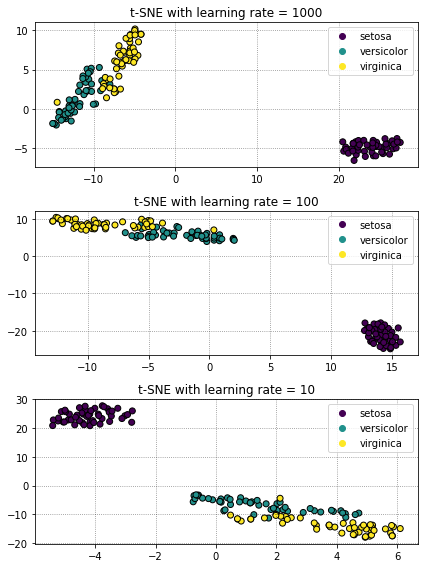

In [51]:
tsne_subplots(iris.data, learning_rates=(1000, 100, 10), color_labels=iris.target, legend_labels=iris.target_names)

A last thing to be aware of, is that the **axes** of a t-SNE plot **don't have any interpretable meaning**. In fact, they are different every time t-SNE is applied. Even on the same data.

## Subsection 4.2 A t-SNE map of the stock market

t-SNE provides great visualizations when the individual samples can be labeled. Here we'll apply t-SNE to the company stock price data. A scatter plot of the resulting t-SNE features, labeled by the company names, gives us a map of the stock market!

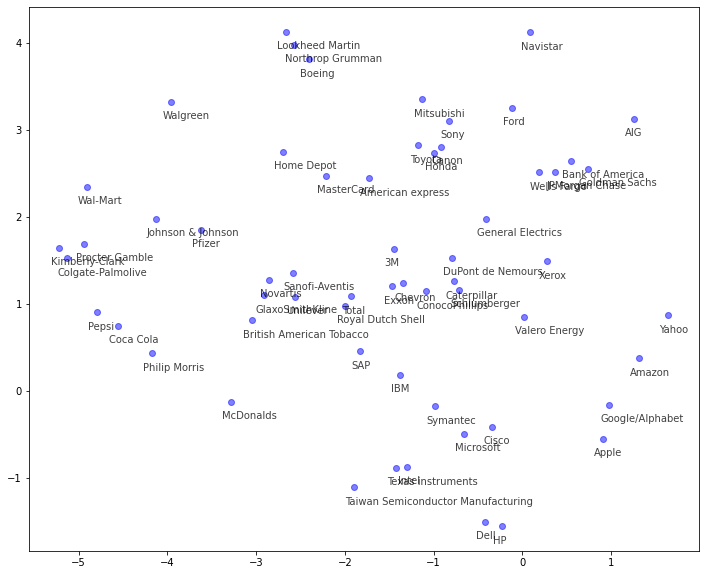

In [52]:
model = TSNE(learning_rate=50)
tsne_features = model.fit_transform(normalized_movements)
xs = tsne_features[:, 0]
ys = tsne_features[:, 1]

fig = plt.figure(figsize=(12, 10))
plt.scatter(xs, ys, alpha=0.5, c='b', edgecolors='b')

# Annotate the points
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x - .1, y - .2), fontsize=10, alpha=0.75)
plt.show()